In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

%config InlineBackend.figure_format = 'svg'

# Start with pure linear regression

In [2]:
three = pickle.load(open("../data/processed/data2.pickle","rb"))

Drop all the data with incomplete FA information.

In [3]:
print(three.shape)

(2260, 52)


Before we proceed, we can eliminate some of the columns as they can be defined in terms of the other. 

$FG = 2P+3P$

$TRB = ORB+DRB$

$TRB\% = ORB\% + DRB\%$

$WS = OWS+DWS$

$BPM = OBPM + DBPM$

$WS/48 = \frac{WS}{48 min}$

We can eliminate at least 6 columns to make things easier. 

In [4]:
columns=['Salary', 'Year', 'Pos', 'Age', 'G', 'GS', 'MP','FGA', 'FG%', '3P', '3PA', '3P%', '2P', 
         '2PA', '2P%', 'eFG%', 'FT','FTA', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%','STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 
         'DWS', 'OBPM','DBPM', 'VORP', 'FA']

In [5]:
df_sm2 = three[columns]
df_sm2.columns = df_sm2.columns.str.replace("%","PCT").str.upper()
df_sm2.columns = df_sm2.columns.str.replace("2","_2").str.replace("3","_3")

In [6]:
del df_sm2["POS"]
del df_sm2["FA"]

In [7]:
df_sm2.columns

Index(['SALARY', 'YEAR', 'AGE', 'G', 'GS', 'MP', 'FGA', 'FGPCT', '_3P', '_3PA',
       '_3PPCT', '_2P', '_2PA', '_2PPCT', 'EFGPCT', 'FT', 'FTA', 'FTPCT',
       'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TSPCT',
       '_3PAR', 'FTR', 'ORBPCT', 'DRBPCT', 'ASTPCT', 'STLPCT', 'BLKPCT',
       'TOVPCT', 'USGPCT', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP'],
      dtype='object')

## Use Statsmodel

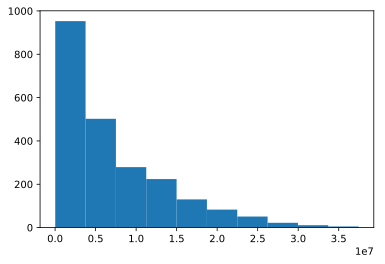

In [8]:
plt.hist(df_sm2['SALARY']);

I tried different transforms out to make the target variable more normal. The best one was the cube root.

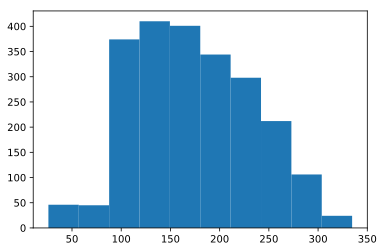

In [12]:
plt.hist(np.cbrt(df_sm2['SALARY']));

In [13]:
df_sm2.SALARY = np.cbrt(df_sm2.SALARY)

/Users/youngjeong/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
y, X= patsy.dmatrices('SALARY ~ G + GS + MP + OBPM + FTA + FT + FGA + _3P+_3PA+_2P + _2PA + ORB+ AST + TOV + STL + DRB + PTS + PER + OWS + DWS + VORP + USGPCT+FGPCT+_3PPCT+_2PPCT+EFGPCT+FTPCT+BLK+PF+TSPCT+_3PAR+FTR+ORBPCT+DRBPCT+ASTPCT+STLPCT+BLKPCT+TOVPCT+DBPM', data=df_sm2, return_type = "dataframe")
model = sm.OLS(y,X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SALARY   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     59.98
Date:                Thu, 18 Apr 2019   Prob (F-statistic):          4.81e-313
Time:                        17:13:44   Log-Likelihood:                -11618.
No. Observations:                2260   AIC:                         2.332e+04
Df Residuals:                    2220   BIC:                         2.354e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.3452     23.955      3.270      0.001      31.368     125.322
G             -0.3267      0.077     -4.219      0.000      -0.478      -0.175
GS             0.0895      0.057      1.579      0.114      -0.022       0.201
MP             1.2597      0.613      2.054      0.040       0.057       2.462
OBPM           1.4079      2.118      0.665      0.506      -2.746       5.562
FTA           -1.7045      5.034     -0.339      0.735     -11.576       8.167
FT            -1.8390     10.217     -0.180      0.857     -21.875      18.196
FGA           10.5743     18.848      0.561      0.575     -26.387      47.536
_3P          -27.2762     25.797     -1.057      0.290     -77.864      23.312
_3PA         -10.8308     18.960     -0.571      0.568     -48.012      26.350
_2P           -5.5284     17.612     -0.314      0.754     -40.066      29.009
_2PA         -21.4154     18.823     -1.138      0.255     -58.328      15.497
ORB            8.4567      4.357      1.941      0.052      -0.087      17.001
AST           18.0452      2.852      6.327      0.000      12.452      23.638
TOV          -20.6563      5.073     -4.072      0.000     -30.604     -10.709
STL          -11.4028      8.239     -1.384      0.166     -27.560       4.754
DRB            2.7784      2.578      1.078      0.281      -2.278       7.834
PTS           16.4200      8.744      1.878      0.061      -0.728      33.568
PER           -4.1688      1.539     -2.710      0.007      -7.186      -1.152
OWS            1.0880      1.864      0.584      0.559      -2.567       4.743
DWS           10.1978      2.311      4.412      0.000       5.665      14.731
VORP          -8.8106      2.837     -3.106      0.002     -14.374      -3.248
USGPCT         2.2176      0.796      2.786      0.005       0.657       3.779
FGPCT        -97.6170    190.047     -0.514      0.608    -470.305     275.071
_3PPCT        -6.5597      8.426     -0.778      0.436     -23.084       9.964
_2PPCT        10.6603     36.539      0.292      0.771     -60.994      82.314
EFGPCT        96.7184    199.189      0.486      0.627    -293.898     487.335
FTPCT         -1.8407     10.878     -0.169      0.866     -23.173      19.491
BLK           -0.9409      6.780     -0.139      0.890     -14.237      12.355
PF           -11.3674      2.436     -4.666      0.000     -16.145      -6.590
TSPCT         90.7338    113.343      0.801      0.423    -131.536     313.004
_3PAR        -34.4056     31.638     -1.087      0.277     -96.449      27.638
FTR          -30.4242     13.839     -2.198      0.028     -57.562      -3.286
ORBPCT         0.6763      0.836      0.809      0.419      -0.963       2.316
DRBPCT         0.7612      0.603      1.262      0.207      -0.422       1.944
ASTPCT        -1.5545      0.467     -3.332      0.001      -2.469      -0.640
ST

In [15]:
y, X= patsy.dmatrices('SALARY ~ G + MP + ORB + AST + TOV + PTS + PER + DWS + VORP + USGPCT + PF + FTR + ASTPCT + TOVPCT + DBPM', data=df_sm2, return_type = "dataframe")
model = sm.OLS(y,X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SALARY   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     143.1
Date:                Thu, 18 Apr 2019   Prob (F-statistic):          3.49e-313
Time:                        17:36:09   Log-Likelihood:                -11672.
No. Observations:                2260   AIC:                         2.338e+04
Df Residuals:                    2244   BIC:                         2.347e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.2343     11.607     10.703      0.000     101.472     146.997
G             -0.2406      0.064     -3.747      0.000      -0.366      -0.115
MP             0.2604      0.424      0.615      0.539      -0.570       1.091
ORB            8.4579      1.850      4.571      0.000       4.829      12.087
AST           14.7537      2.402      6.142      0.000      10.043      19.464
TOV          -10.8759      4.199     -2.590      0.010     -19.111      -2.641
PTS            6.7507      0.872      7.744      0.000       5.041       8.460
PER            0.1322      0.460      0.288      0.774      -0.769       1.034
DWS           10.3655      1.823      5.687      0.000       6.791      13.940
VORP          -3.7870      1.421     -2.664      0.008      -6.574      -1.000
USGPCT        -0.7696      0.538     -1.431      0.153      -1.824       0.285
PF            -7.9781      2.088     -3.821      0.000     -12.073      -3.884
FTR          -11.4625      7.029     -1.631      0.103     -25.246       2.321
ASTPCT        -2.1479      0.390     -5.513      0.000      -2.912      -1.384
TOVPCT         1.0103      0.285      3.542      0.000       0.451       1.570
DBPM           1.3866      0.871      1.592      0.112      -0.321       3.095
==============================================================================
Omnibus:                        9.008   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.670
Skew:                           0.108   Prob(JB):                      0.00795
Kurtosis:                       3.236   Cond. No.                         995.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

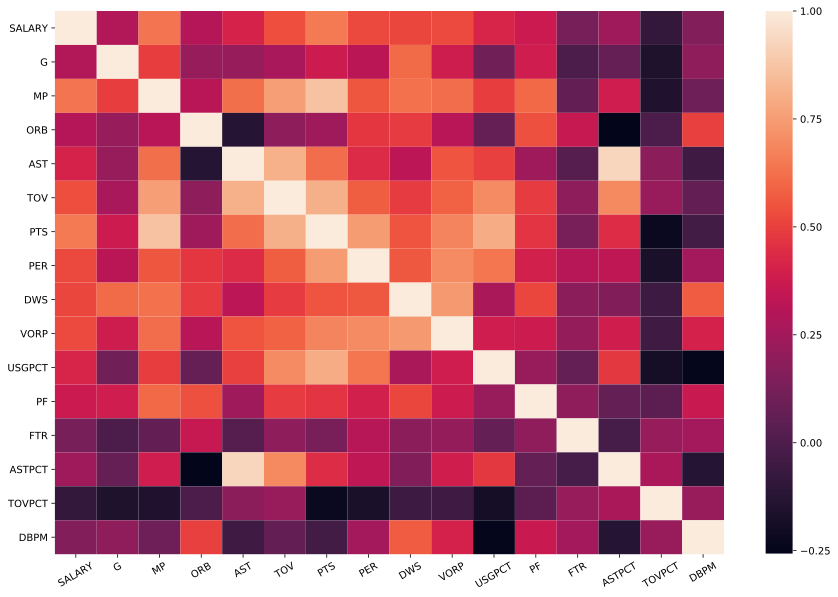

In [17]:
plt.figure(figsize=(15,10))

sns.heatmap((df_sm2[['SALARY','G','MP','ORB','AST','TOV','PTS','PER','DWS','VORP','USGPCT','PF','FTR','ASTPCT','TOVPCT','DBPM']]).corr()
            , xticklabels=['SALARY','G','MP','ORB','AST','TOV','PTS','PER','DWS','VORP','USGPCT','PF','FTR','ASTPCT','TOVPCT','DBPM']
            , yticklabels=['SALARY','G','MP','ORB','AST','TOV','PTS','PER','DWS','VORP','USGPCT','PF','FTR','ASTPCT','TOVPCT','DBPM'])

plt.xticks(np.arange(0.5, 16, step=1), rotation=30); 

## Starting Dataframe

Create a smaller DF we can start with.

In [20]:
# df_sm2 = three[columns] 
df_sm2 = three[['Salary','Year','G','MP','ORB','AST','TOV','PTS','PER','DWS','VORP','USG%','PF','FTr','AST%','TOV%','DBPM']]
# df_sm2 = three[['Salary','Year','G','ORB','AST','TOV','PTS','DWS','VORP','USG%','PF','AST%','DBPM']]
df_sm2.columns = df_sm2.columns.str.replace("%","PCT").str.upper()
df_sm2.columns = df_sm2.columns.str.replace("2","_2").str.replace("3","_3")

In [21]:
# df_sm2 = df_sm2[df_sm2.PER > 0]
# df_sm2 = df_sm2[df_sm2.PF < 6]
# df_sm2 = df_sm2[(df_sm2["_2PPCT"] < 1.0) & (df_sm2["_2PPCT"] > 0)]
# df_sm2 = df_sm2[(df_sm2["_3PPCT"] < 1.0) & (df_sm2["_3PPCT"] > 0)]
# df_sm2 = df_sm2[(df_sm2["FGPCT"] < 1.0) & (df_sm2["FGPCT"] > 0)]
# df_sm2 = df_sm2[(df_sm2["FTPCT"] < 1.0) & (df_sm2["FTPCT"] > 0)]
# df_sm2 = df_sm2[df_sm2["G"] > 0]

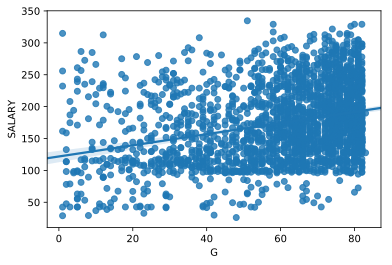

In [22]:
sns.regplot(df_sm2.G,np.cbrt(df_sm2.SALARY));

In [ ]:
pp = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['AGE', 'G', 'GS', 'MP'])

In [ ]:
pp2 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['FGA', 'FGPCT', '_3P', '_3PA', '_3PPCT'])

In [ ]:
pp3 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['_2P', '_2PA', '_2PPCT', 'EFGPCT', 'FT'])

In [ ]:
pp4 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['FTA', 'FTPCT', 'ORB', 'DRB', 'AST'])


In [ ]:
pp5 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['STL', 'BLK', 'TOV', 'PF','PTS'])


In [ ]:
pp6 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['PER', 'TSPCT', '_3PAR', 'FTR', 'ORBPCT'])


In [ ]:
pp7 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['DRBPCT', 'ASTPCT','STLPCT', 'BLKPCT', 'TOVPCT'])


In [ ]:
pp8 = sns.pairplot(data=df_sm2,
                  y_vars=['SALARY'],
                  x_vars=['USGPCT', 'OWS','DWS', 'OBPM','DBPM', 'VORP'])

In [27]:
def lr_test(dataset, target):
    test = dataset[(dataset.YEAR == 2018)]
    train = dataset[dataset.YEAR != 2018]
    test = test.drop('YEAR', axis=1)
    train = train.drop('YEAR', axis=1)
    
    X_test, y_test = pd.get_dummies(test[test.columns[1:]]), test[target]
    X_train, y_train = pd.get_dummies(train[train.columns[1:]]), np.cbrt(train[target])

#     print(X_train.columns)
#     print(X_test.columns)
#     print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    r2 = lr.score(X_train, y_train)
#     r2_poly = lm_poly.score(X_train_poly, y_train)
    N = X_train.shape[0]
    p = X_train.shape[1]
    
    adjusted_r2 = 1-((1-r2**2)*(N-1)/(N-p-1))
    # Print out the R^2 for the model against the full dataset
    print(f'Linear Regression R2 score: {r2:.6f}')
    print(f'Adjusted R2 Score: {adjusted_r2: .6f}')
#     print(f'\nPolynomial Regression R2 score: {r2_poly:.6f}')
#     print(f'Polynomial Adjusted R2 Score: {adjusted_r2_poly: .6f}')
    
    
    
    # Predictions
    y_pred = lr.predict(X_test)
#     y_pred_poly = lm_poly.predict(X_test_poly)
    
    
    
    print("\nLR Test Data R2 score: ", r2_score(y_test,y_pred**3))
    print("LR Test MAE: ", mean_absolute_error(y_test,y_pred**3))
    print("Median 2018 NBA Salary: ", y_test.median())
    print("Mean 2018 NBA Salary: ", y_test.mean())
    print("Median predicted Salary: ", np.median(y_pred**3))
    
#     plt.figure(figsize=(20,10))
#     plt.subplot(1,2,1)
    
#     res = y_test - y_pred**3
    
#     plt.scatter(y_pred**3,res)
#     plt.title("Residual Plot of 2018 NBA SALARY Prediction")
#     plt.xlabel("Prediction (10 Million $)")
#     plt.ylabel("Residuals (10 Million $)")
    
#     plt.subplot(1,2,2)
    
#     plt.scatter(y_pred**3, y_test)
#     plt.title("Salary: Actual VS Prediction")
#     plt.xlabel("Prediction (10 Million $)")
#     plt.ylabel("Actual (10 Million $)")
    
    return y_pred, lr#, lm_poly

## Polynomial Terms - ^2, sqrt, interaction terms, etc.

In [28]:
y_pred, lr1 = lr_test(df_sm2, "SALARY")

Linear Regression R2 score: 0.505045
Adjusted R2 Score:  0.249232

LR Test Data R2 score:  0.30613163743871474
LR Test MAE:  5091888.859591299
Median 2018 NBA Salary:  7000000.0
Mean 2018 NBA Salary:  9558095.951515151
Median predicted Salary:  4667143.632683283


Add the square terms:

In [29]:
features = ['G','ORB','AST','TOV','PTS','DWS','VORP','USGPCT','PF','ASTPCT','DBPM']
df_sm2_2 = df_sm2.copy()
for fea in features:
    df_sm2_2[fea+"2"] = df_sm2[fea]**2
y_pred, lr2 = lr_test(df_sm2_2,"SALARY")

Linear Regression R2 score: 0.517131
Adjusted R2 Score:  0.257415

LR Test Data R2 score:  0.3123044996761797
LR Test MAE:  5070143.299831751
Median 2018 NBA Salary:  7000000.0
Mean 2018 NBA Salary:  9558095.951515151
Median predicted Salary:  4904633.426947447


Then the Interaction terms:

In [31]:
df_sm2_3 = df_sm2_2.copy()
for item in itertools.combinations(features,2):
    df_sm2_2[item[0]+item[1]] = df_sm2[item[0]]*df_sm2[item[1]]
y_pred, lr3 = lr_test(df_sm2_3,"SALARY")

Linear Regression R2 score: 0.517131
Adjusted R2 Score:  0.257415

LR Test Data R2 score:  0.3123044996761797
LR Test MAE:  5070143.299831751
Median 2018 NBA Salary:  7000000.0
Mean 2018 NBA Salary:  9558095.951515151
Median predicted Salary:  4904633.426947447


In [ ]:
df_sm2_3 = df_sm2.copy()
df_sm2_2["PTSG"] = df_sm2["PTS"]*df_sm2["G"]
y_pred, lr2 = lr_test(df_sm2_2, "SALARY")

In [ ]:
df_sm2_3 = df_sm2_2.copy()
df_sm2_3["PF2"] = df_sm2["PF"]**2
y_pred, lr3 = lr_test(df_sm2_3, "SALARY")

In [ ]:
df_sm2_4 = df_sm2_3.copy()
df_sm2_4["PF2"] = df_sm2["PF"]**2
y_pred, lr4 = lr_test(df_sm2_4, "SALARY")

In [ ]:
df_sm2_5 = df_sm2_4.copy()
df_sm2_5["DRBPCT2"] = df_sm2["DRBPCT"]**2
y_pred, lr5 = lr_test(df_sm2_5, "SALARY")

In [ ]:
df_sm2_6 = df_sm2_5.copy()
df_sm2_6["G2"] = df_sm2["G"]**2
y_pred, lr6 = lr_test(df_sm2_6, "SALARY")

In [ ]:
df_sm2_7 = df_sm2_6.copy()
df_sm2_7["PTSG"] = df_sm2["PTS"]*df_sm2["G"]
y_pred, lr7 = lr_test(df_sm2_7, "SALARY")

In [ ]:
df_sm2_8 = df_sm2_7.copy()
df_sm2_8["ASTG"] = df_sm2["AST"]*df_sm2["G"]
df_sm2_8["TOVG"] = df_sm2["TOV"]*df_sm2["G"]
df_sm2_8["VORPG"] = df_sm2["VORP"]*df_sm2["G"]
y_pred, lr8 = lr_test(df_sm2_8, "SALARY")

In [ ]:
pickle.dump(lr6, open("../models/LR.pickle", 'wb'))

## Cross-Validation & adding Ridge Regularization

In [ ]:
def cross_val(dataset):
    
    # Split out the y (keep the Year on both for test/train split)
    X,y = dataset.drop('SALARY',axis=1), dataset[['YEAR','SALARY']]
    
    # Test/Train split
    X,X_test = X[X.YEAR != 2018],X[X.YEAR==2018]
    y,y_test = y[y.YEAR != 2018],y[y.YEAR==2018]
    
#     print(X_test.shape, y_test.shape)
    
    # Drop the Year column on Test data first
    y_test = y_test.drop('YEAR',axis=1)
    X_test = X_test.drop('YEAR',axis=1)
    
    LR_r2s, LM_REG_r2s = [],[]
    LR_MAES, LM_REG_MAES = [],[]
    
    for i in range(2017,2013,-1):
#         print("Val = Year ", str(i))
        years = [i-j for j in range(1,4)]
#         print(years)
        X_val,y_val = X[X.YEAR == i], y[y.YEAR == i]
        X_val = X_val.drop('YEAR', axis=1)
        y_val = y_val.drop('YEAR', axis=1)
#         print(X_val.shape, y_val.shape)
        X_train, y_train = X[X.YEAR.isin(years)], y[y.YEAR.isin(years)]
        X_train = X_train.drop('YEAR', axis=1)
        y_train = y_train.drop('YEAR', axis=1)
#         print(X_train.shape, y_train.shape)
#         print(X_train.columns)
#         print(y_train.columns)
        
        
        # Set dummies
        X_val,X_test,X_train = pd.get_dummies(X_val), pd.get_dummies(X_test), pd.get_dummies(X_train)

         #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=1)

        lm.fit(X_train, y_train)
        LR_r2s.append(lm.score(X_val, y_val))
        y_pred = lm.predict(X_val)
        LR_MAES.append(mean_absolute_error(y_pred,y_val))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        lm_reg.fit(X_train_scaled, y_train)
        LM_REG_r2s.append(lm_reg.score(X_val_scaled, y_val))
        y_pred_reg = lm_reg.predict(X_val_scaled)
        LM_REG_MAES.append(mean_absolute_error(y_pred_reg,y_val))
    
#     print(LR_r2s)
#     print(LR_MAES)
    mean_MAE_LR = np.mean(LR_MAES)
    mean_MAE_REG = np.mean(LM_REG_MAES)
    print("Average R2 Score of Linear Regression: ", np.mean(LR_r2s))
    print("Average MAE of Linear Regression: ", mean_MAE_LR)
#     print(LM_REG_r2s)
#     print(LM_REG_MAES)
    print("Average R2 Score of Ridge Regression w/ Scaler: ", np.mean(LM_REG_r2s))
    print("Average MAE of Ridge Regression: ", mean_MAE_REG)
    
    # Test on the whole training set
    y = y.drop('YEAR',axis=1)
    X = X.drop('YEAR',axis=1)
    X = pd.get_dummies(X)
    X_te = scaler.transform(X)
    
    if mean_MAE_REG < mean_MAE_LR:
        print("\nRidge Regression performs better")
        pred = lm_reg.predict(X_te)
    else:
        print("\nLinear Regression performs better")
        pred = lm.predict(X)
    
#     print()
    print("MAE on the whole training set: ", mean_absolute_error(pred,y))
    
    X_test_te = scaler.transform(X_test)
    pred_test = lm_reg.predict(X_test_te)
    print("MAE on the test set: ", mean_absolute_error(pred_test,y_test))
    
    res = pred_test-y_test

#     plt.figure(figsize=(20,10))

#     plt.scatter(pred_test,res)
#     plt.title("Residual Plot of 2018 NBA SALARY Prediction")
#     plt.xlabel("Prediction (10 Million $)")
#     plt.ylabel("Residuals (10 Million $)")    

    
    return lm_reg, lm, pred_test, y_test

In [ ]:
lm_reg_cv, lm_cv, pred_test, y_test = cross_val(df_sm2_6)

In [ ]:
def ridge_test(dataset):
    
    # Split out the y (keep the Year on both for test/train split)
    X,y = dataset.drop('SALARY',axis=1), dataset[['YEAR','SALARY']]
    
    # Test/Train split
    X,X_test = X[X.YEAR != 2018],X[X.YEAR==2018]
    y,y_test = y[y.YEAR != 2018],y[y.YEAR==2018]
    
#     print(X_test.shape, y_test.shape)
    
    # Drop the Year column on Test data first
    y_test = y_test.drop('YEAR',axis=1)
    X_test = X_test.drop('YEAR',axis=1)
    
    for i in range(2017,2013,-1):
#         print("Val = Year ", str(i))
        years = [i-j for j in range(1,4)]
#         print(years)
        X_val,y_val = X[X.YEAR == i], y[y.YEAR == i]
        X_val = X_val.drop('YEAR', axis=1)
        y_val = y_val.drop('YEAR', axis=1)
#         print(X_val.shape, y_val.shape)
        X_train, y_train = X[X.YEAR.isin(years)], y[y.YEAR.isin(years)]
        X_train = X_train.drop('YEAR', axis=1)
        y_train = y_train.drop('YEAR', axis=1)
#         print(X_train.shape, y_train.shape)
#         print(X_train.columns)
#         print(y_train.columns)
        
        
        # Set dummies
        X_val,X_test,X_train = pd.get_dummies(X_val), pd.get_dummies(X_test), pd.get_dummies(X_train)
        values = []
        
        #
        alphalist = 10**(np.linspace(-2,2,200))
        err_vec_val = np.zeros(len(alphalist))
        err_vec_train = np.zeros(len(alphalist))

        for k,curr_alpha in enumerate(alphalist):

            # note the use of a new sklearn utility: Pipeline to pack
            # multiple modeling steps into one fitting process 
            steps = [('standardize', StandardScaler()), 
                     ('ridge', Ridge(alpha = curr_alpha))]

            pipe = Pipeline(steps)
            pipe.fit(X_train.values, y_train)

            val_set_pred = pipe.predict(X_val.values)
            err_vec_val[k] = mean_absolute_error(y_val, val_set_pred)
        
        print("Minimum MAE: ", np.min(err_vec_val))
        print("When alpha = ", alphalist[np.argmin(err_vec_val)])
#             plt.plot(np.log10(alphalist), err_vec_val)
        
#         # ridge with feature scaling
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_val_scaled = scaler.transform(X_val)
        
#         # fit and predict
#         lm_reg.fit(X_train_scaled, y_train)
#         LM_REG_r2s.append(lm_reg.score(X_val_scaled, y_val))
#         y_pred_reg = lm_reg.predict(X_val_scaled)
#         LM_REG_MAES.append(mean_absolute_error(y_pred_reg,y_val))
    
# #     print(LR_r2s)
# #     print(LR_MAES)
#     mean_MAE_LR = np.mean(LR_MAES)
#     mean_MAE_REG = np.mean(LM_REG_MAES)
#     print("Average R2 Score of Linear Regression: ", np.mean(LR_r2s))
#     print("Average MAE of Linear Regression: ", mean_MAE_LR)
# #     print(LM_REG_r2s)
# #     print(LM_REG_MAES)
#     print("Average R2 Score of Ridge Regression w/ Scaler: ", np.mean(LM_REG_r2s))
#     print("Average MAE of Ridge Regression: ", mean_MAE_REG)
    
#     # Test on the whole training set
#     y = y.drop('YEAR',axis=1)
#     X = X.drop('YEAR',axis=1)
#     X = pd.get_dummies(X)
#     X_te = scaler.transform(X)
    
#     if mean_MAE_REG < mean_MAE_LR:
#         print("\nRidge Regression performs better")
#         pred = lm_reg.predict(X_te)
#     else:
#         print("\nLinear Regression performs better")
#         pred = lm.predict(X)
    
# #     print()
#     print("MAE on the whole training set: ", mean_absolute_error(pred,y))
    
#     X_test_te = scaler.transform(X_test)
#     pred_test = lm_reg.predict(X_test_te)
#     print("MAE on the test set: ", mean_absolute_error(pred_test,y_test))
    
#     res = pred_test-y_test

#     plt.figure(figsize=(20,10))

#     plt.scatter(pred_test,res)
#     plt.title("Residual Plot of 2018 NBA SALARY Prediction")
#     plt.xlabel("Prediction (10 Million $)")
#     plt.ylabel("Residuals (10 Million $)")    

    
    return steps, pred_test, y_test

In [ ]:
lm_reg_cv, pred_test, y_test = ridge_test(df_sm2_6)